In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, auc, precision_recall_curve, confusion_matrix,
                           classification_report, average_precision_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve
from itertools import cycle

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/merged_V2.csv')

In [ ]:
df = df.drop('image_filename', axis=1)

In [ ]:
import numpy as np

def add_adversarial_noise_optimized(df, epsilon=2.0):
    # 필요한 컬럼 리스트
    columns = [col for col in df.columns if '_x' in col or '_y' in col]
    # 원본 복사는 최소한으로 (필요한 부분만 복사)
    df_adv = df.copy(deep=False)  # 얕은 복사: 메모리 사용량이 줄어듦 (단, 내부 데이터가 수정되면 원본에도 영향이 있을 수 있음)

    # 모든 SMA 컬럼에 대해 한 번에 noise 행렬 생성 후 적용
    noise = np.random.uniform(-epsilon, epsilon, size=(df_adv.shape[0], len(columns)))
    df_adv.loc[:, columns] = df_adv.loc[:, columns] + noise
    return df_adv

# 최적화된 함수 사용
df_adv = add_adversarial_noise_optimized(df, epsilon=2.0)

In [ ]:
encoder = LabelEncoder()
encoder.fit(df['label'])

df["label"] = encoder.transform(df["label"])
df
# 0 = jump, 1 = spin, 2 = step

,Nose_x,Nose_y,LEye_x,LEye_y,REye_x,REye_y,LEar_x,LEar_y,REar_x,REar_y,...,RSmallToe_x,RSmallToe_y,LHeel_x,LHeel_y,RHeel_x,RHeel_y,gender,level,label,path
0,1368.414925,245.486335,1374.042370,242.758567,1368.891680,239.801444,1390.538418,246.214988,1387.755328,245.460399,...,1355.338345,464.647047,1384.846272,457.655039,1387.394367,458.361706,0,1,0,Jump/1F(Flip)/넘어짐/고급/FA10/1/camera0/video/Moti...
1,1365.883436,246.593450,1374.205366,241.472678,1368.833091,240.915508,1387.747850,244.155757,1384.786121,246.767324,...,1352.504562,463.390673,1387.257161,457.793773,1384.892888,456.654731,0,1,0,Jump/1F(Flip)/넘어짐/고급/FA10/1/camera0/video/Moti...
2,1366.350770,247.362283,1373.897672,244.723651,1364.177240,244.768537,1386.181949,246.800663,1383.092836,247.065083,...,1356.920704,465.321040,1380.657508,459.362626,1388.184376,454.482495,0,1,0,Jump/1F(Flip)/넘어짐/고급/FA10/1/camera0/video/Moti...
3,1364.665221,247.949444,1372.958663,242.719223,1366.770422,242.637186,1385.778368,246.236832,1382.062757,245.513966,...,1356.256831,464.525419,1382.433700,459.072888,1389.468571,456.618398,0,1,0,Jump/1F(Flip)/넘어짐/고급/FA10/1/camera0/video/Moti...
4,1360.939207,246.368762,1368.752267,241.237069,1363.283716,240.293489,1380.743608,246.394643,1381.946885,248.722897,...,1354.695210,462.636689,1388.923697,459.583849,1389.583847,455.785716,0,1,0,Jump/1F(Flip)/넘어짐/고급/FA10/1/camera0/video/Moti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196118,560.304393,499.987685,571.795832,486.427903,553.640724,489.442702,595.101169,487.297597,551.111458,489.180919,...,569.234539,858.881333,629.483889,834.008568,599.579141,832.189433,1,1,2,Step/Stroking/정상/고급/FA02/5/camera7/video/Motio...
10196119,552.872680,502.779242,566.062403,494.142495,548.823482,494.343724,587.509008,488.830962,545.913720,491.464306,...,557.550461,860.248181,623.702613,843.035178,594.615052,833.743049,1,1,2,Step/Stroking/정상/고급/FA02/5/camera7/video/Motio...
10196120,549.395323,506.496068,563.237593,497.501037,539.293052,498.337240,585.206166,491.255518,536.254530,497.172925,...,553.836898,869.203301,617.422268,850.068008,588.091239,842.403115,1,1,2,Step/Stroking/정상/고급/FA02/5/camera7/video/Motio...
10196121,545.084446,514.565004,556.318029,502.022421,540.319955,504.174533,579.780923,495.721207,535.725663,503.648236,...,547.536937,870.576672,611.866542,860.615709,581.882217,849.497601,1,1,2,Step/Stroking/정상/고급/FA02/5/camera7/video/Motio...


In [ ]:
X = df.drop(['label', 'level','gender', 'path'] , axis=1)
Y = df['label']

print(X.shape)
print(Y.shape)

(10196123, 52)
(10196123,)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y, test_size=0.2, random_state=42, stratify=Y
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(6525518, 52)
(2039225, 52)
(6525518,)
(2039225,)
(1631380, 52)
(1631380,)


In [ ]:
# 모델 정의
models = {
    'Extra Trees': ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(iterations=50, random_state=42, verbose=0),
    'LightGBM': LGBMClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    #'XGBoost': XGBClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    #'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
}

In [ ]:
kf = KFold(n_splits=5, shuffle=False)
cv_scores = []

In [ ]:
# 각 모델별 Test 예측값을 저장할 리스트
test_predictions = {name: np.zeros((X_test.shape[0], len(np.unique(Y_test)))) for name in models.keys()}

# KFold 적용
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n=== Fold {fold+1} ===")

    # KFold 데이터 분할
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

    for name, model in models.items():
        print(f"\n--- Training {name} ---")

        # 모델 학습
        model.fit(X_train_fold, Y_train_fold)

        # 훈련 세트 성능 평가
        Y_train_pred = model.predict(X_train_fold)
        print("\n--- Training Set Performance ---")
        print(classification_report(Y_train_fold, Y_train_pred))

        # 검증 세트 성능 평가
        Y_val_pred = model.predict(X_val_fold)
        print("\n--- Validation Set Performance ---")
        print(classification_report(Y_val_fold, Y_val_pred))

        # Test Set 예측값 저장 (Soft Voting을 위해 확률 예측값 사용)
        test_predictions[name] += model.predict_proba(X_test) / kf.n_splits  # 평균 계산

# 최종 테스트 세트 평가 (앙상블 방식)
for name, pred_proba in test_predictions.items():
    print(f"\n=== Final Test Evaluation ({name}) - Averaged Over Folds ===")

    # 확률 예측값을 가장 높은 클래스 선택으로 변환
    Y_test_pred = np.argmax(pred_proba, axis=1)

    print("\n--- Test Set Performance ---")
    print(classification_report(Y_test, Y_test_pred))


=== Fold 1 ===

--- Training Extra Trees ---

--- Training Set Performance ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2357516
           1       1.00      1.00      1.00   1681554
           2       1.00      1.00      1.00   1181344

    accuracy                           1.00   5220414
   macro avg       1.00      1.00      1.00   5220414
weighted avg       1.00      1.00      1.00   5220414


--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.89      0.92      0.91    590021
           1       0.89      0.89      0.89    420720
           2       0.91      0.85      0.88    294363

    accuracy                           0.89   1305104
   macro avg       0.90      0.89      0.89   1305104
weighted avg       0.89      0.89      0.89   1305104


--- Training CatBoost ---

--- Training Set Performance ---
              precision    recall  f1-score   support

      


=== Confusion Matrix (Extra Trees) ===


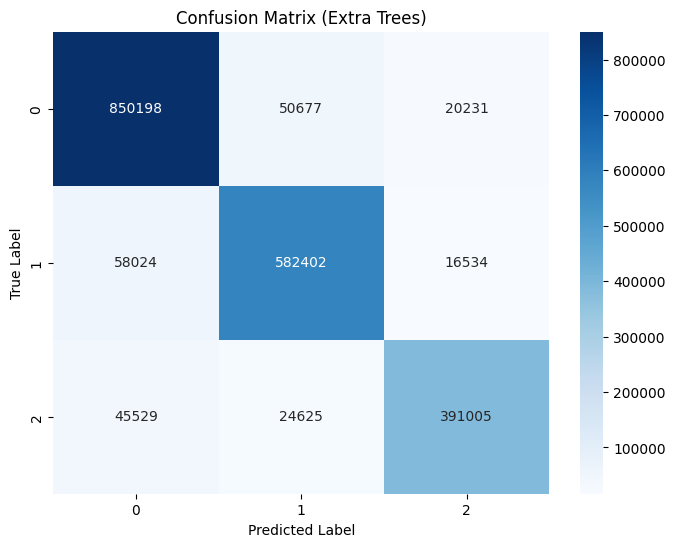


=== Confusion Matrix (CatBoost) ===


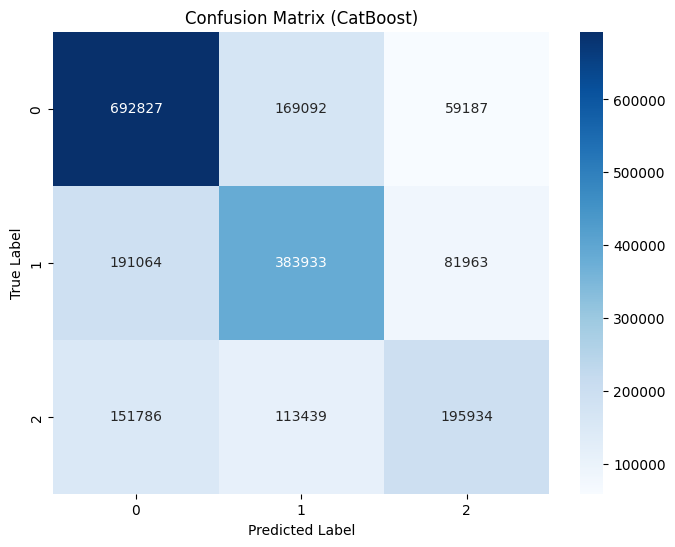


=== Confusion Matrix (LightGBM) ===


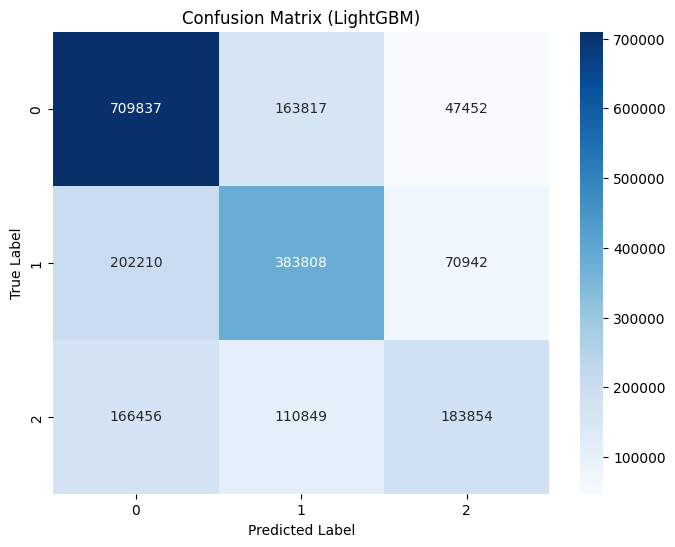

In [ ]:
class_names = np.unique(Y_test)

for name, model in models.items():
    print(f"\n=== Confusion Matrix ({name}) ===")

    Y_test_pred = model.predict(X_test)

    cm = confusion_matrix(Y_test, Y_test_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f'Confusion Matrix ({name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Extra Trees Y_test_pred shape: (2039225,)
Extra Trees Y_test_pred (first 5): [2 1 1 1 0]


<ipython-input-16-3de0daae41cf>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


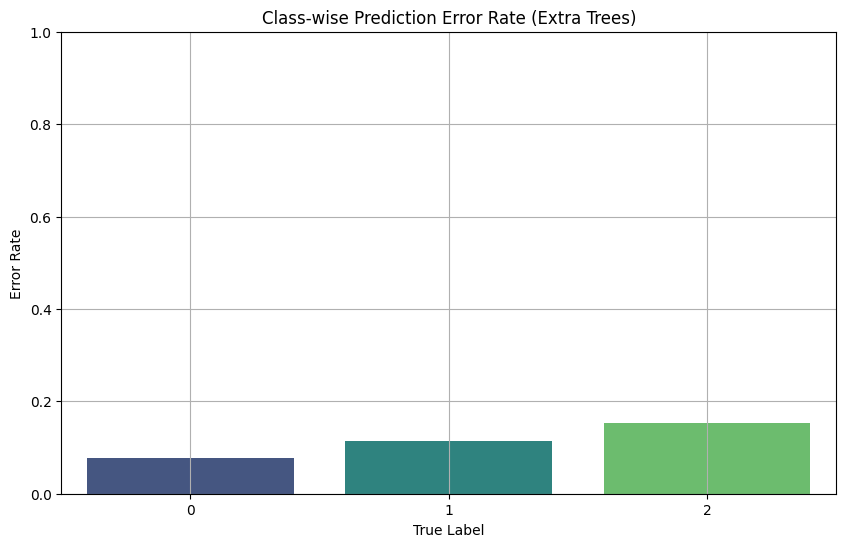

True Label
0    0.076981
1    0.113489
2    0.152125
Name: Error, dtype: float64
CatBoost Y_test_pred shape: (2039225, 1)
CatBoost Y_test_pred (first 5): [0 1 1 1 0]


<ipython-input-16-3de0daae41cf>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


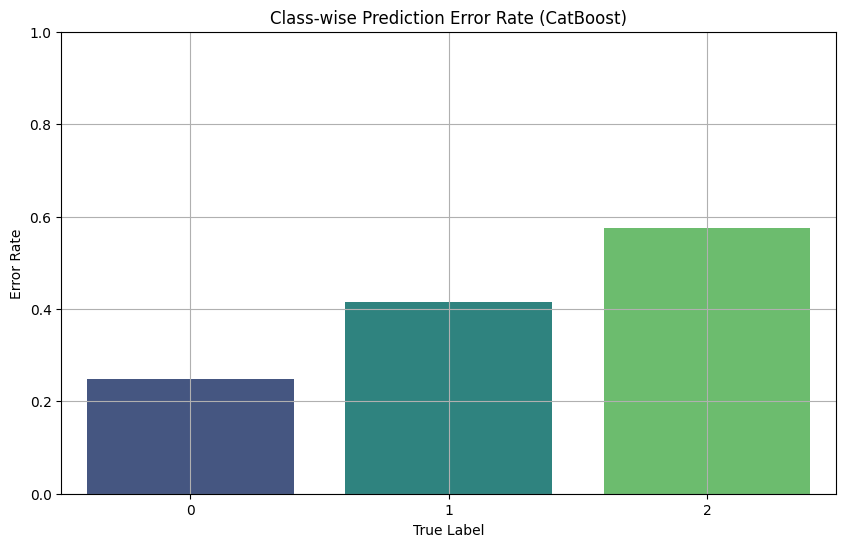

True Label
0    0.247831
1    0.415592
2    0.575127
Name: Error, dtype: float64
LightGBM Y_test_pred shape: (2039225,)
LightGBM Y_test_pred (first 5): [0 1 1 1 0]


<ipython-input-16-3de0daae41cf>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


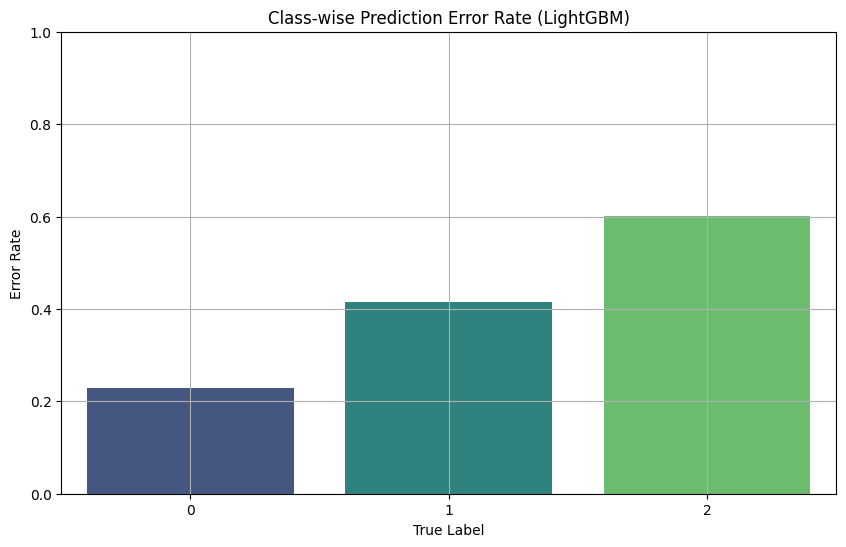

True Label
0    0.229364
1    0.415782
2    0.601322
Name: Error, dtype: float64


In [ ]:
for name, model in models.items():    # print(f"\n=== Evaluating {name} ===")

    # 예측값 생성
    Y_test_pred = model.predict(X_test)

    # 예측값 차원 확인
    print(f"{name} Y_test_pred shape: {Y_test_pred.shape}")

    # 1차원 변환 (필요할 경우)
    if Y_test_pred.ndim > 1:
        if Y_test_pred.shape[1] > 1:
            print(f"Warning: {name} predict() returned probabilities! Using argmax().")
            Y_test_pred = Y_test_pred.argmax(axis=1)
        else:
            Y_test_pred = Y_test_pred.ravel()

    print(f"{name} Y_test_pred (first 5): {Y_test_pred[:5]}")

    # 예측 오류 분석
    error = pd.DataFrame({
        "True Label": Y_test,
        "Predicted Label": Y_test_pred
    })

    error["Error"] = (error["True Label"] != error["Predicted Label"]).astype(int)
    classwise_error = error.groupby("True Label")["Error"].mean()

    # 클래스별 오류 비율 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")
    plt.title(f"Class-wise Prediction Error Rate ({name})")
    plt.xlabel("True Label")
    plt.ylabel("Error Rate")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    print(classwise_error)



=== ROC Curve Analysis (Extra Trees) ===


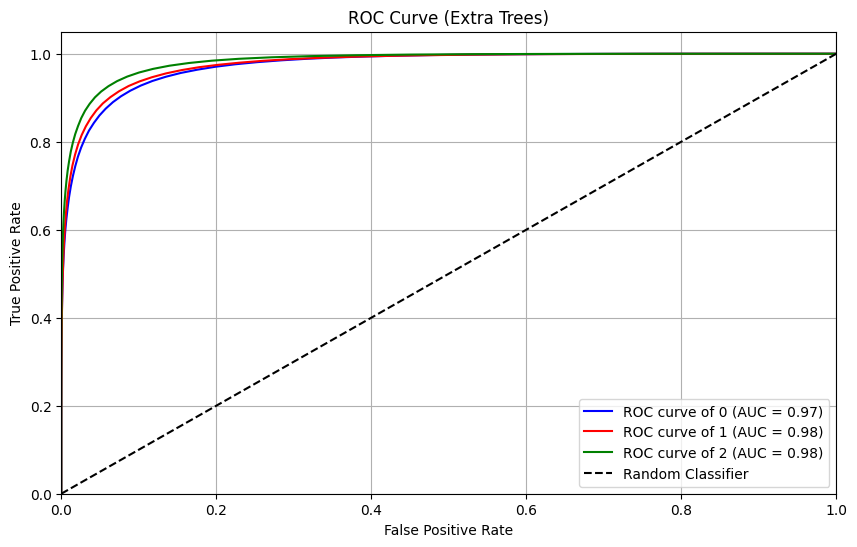


=== AUC Scores ===
0: 0.974
1: 0.977
2: 0.983

=== ROC Curve Analysis (CatBoost) ===


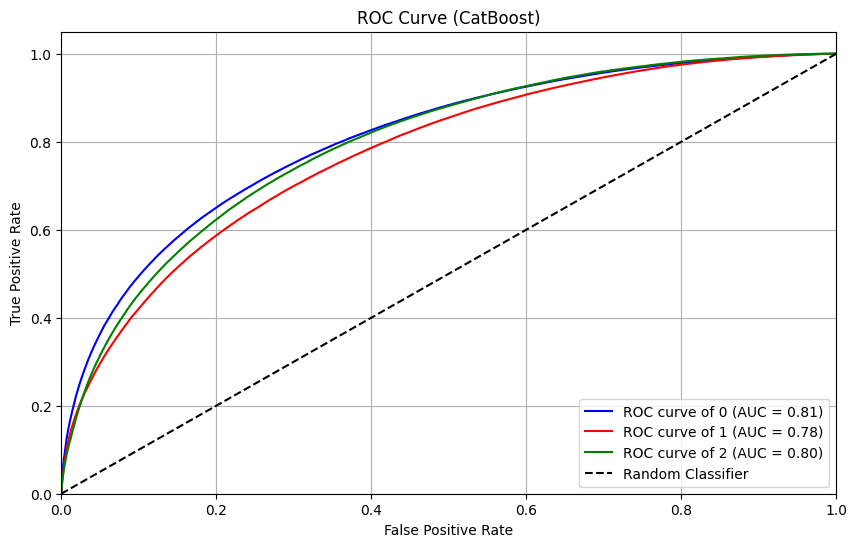


=== AUC Scores ===
0: 0.807
1: 0.775
2: 0.796

=== ROC Curve Analysis (LightGBM) ===


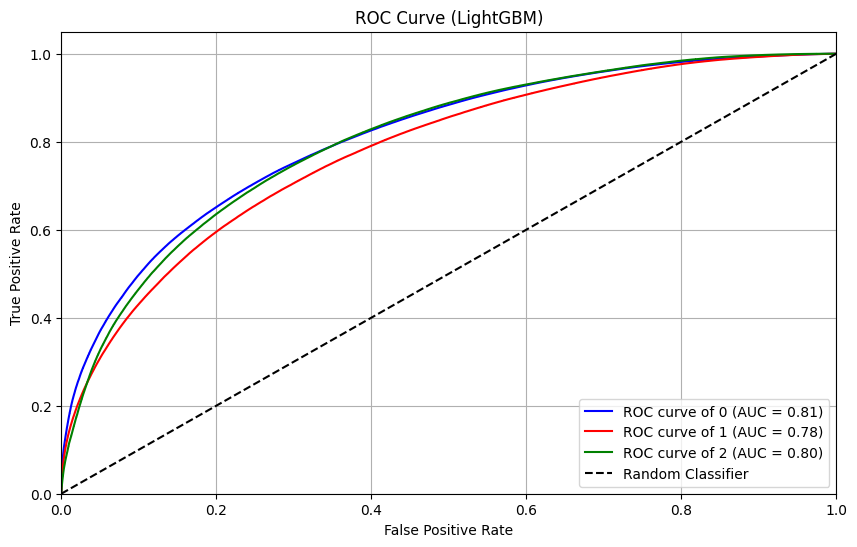


=== AUC Scores ===
0: 0.809
1: 0.779
2: 0.802


In [ ]:
for name, model in models.items():
    print(f"\n=== ROC Curve Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 FPR, TPR, AUC 저장
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    auc_scores = {}

    # 클래스별 ROC 곡선 계산
    for i, class_name in enumerate(np.unique(Y)):
        fpr[i], tpr[i], _ = roc_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 ROC 변환
            y_pred_proba[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])
        auc_scores[class_name] = roc_auc[i]

    # ROC 커브 그리기
    plt.figure(figsize=(10, 6))
    colors = cycle(['blue', 'red', 'green'])

    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            label=f'ROC curve of {class_name} (AUC = {roc_auc[i]:.2f})'
        )

    # 완벽한 예측선을 추가
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({name})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # AUC 점수 출력
    print("\n=== AUC Scores ===")
    for class_name, score in auc_scores.items():
        print(f"{class_name}: {score:.3f}")




=== Precision-Recall Curve Analysis (Extra Trees) ===


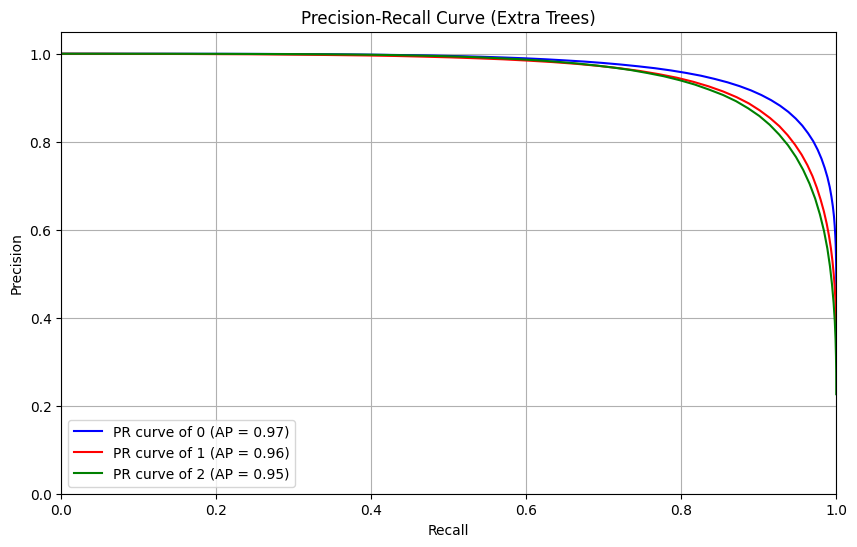


=== Average Precision Scores ===
0: 0.969
1: 0.956
2: 0.952

=== Precision-Recall Curve Analysis (CatBoost) ===


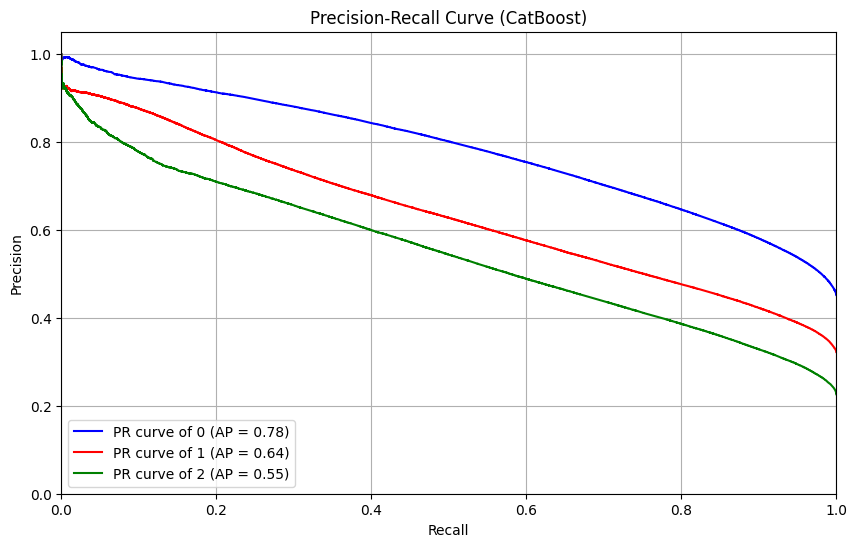


=== Average Precision Scores ===
0: 0.780
1: 0.636
2: 0.550

=== Precision-Recall Curve Analysis (LightGBM) ===


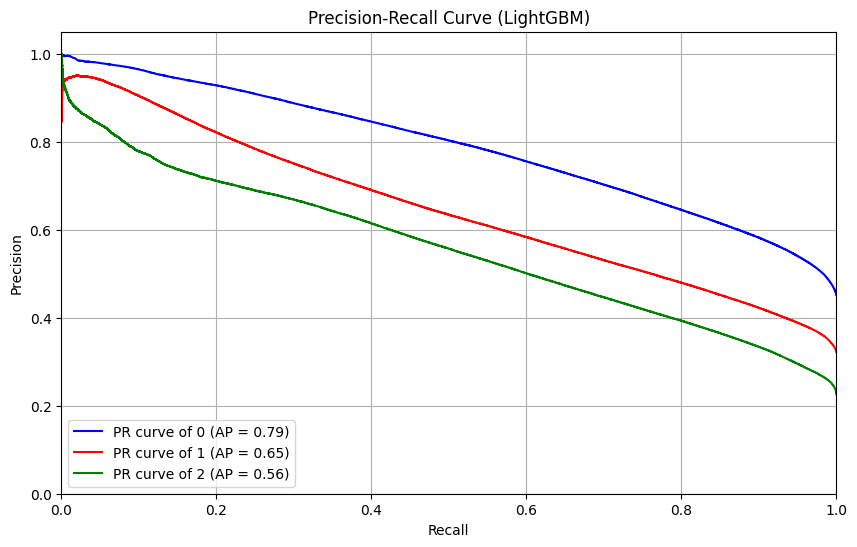


=== Average Precision Scores ===
0: 0.786
1: 0.647
2: 0.558


In [ ]:
for name, model in models.items():
    print(f"\n=== Precision-Recall Curve Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 Precision, Recall, AP 저장
    precision = dict()
    recall = dict()
    avg_precision = dict()
    ap_scores = {}

    # 클래스별 PR 곡선 계산
    for i, class_name in enumerate(np.unique(Y)):
        precision[i], recall[i], _ = precision_recall_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 PR 변환
            y_pred_proba[:, i]
        )
        avg_precision[i] = average_precision_score(
            (Y_test == class_name).astype(int),
            y_pred_proba[:, i]
        )
        ap_scores[class_name] = avg_precision[i]

    # PR 커브 그리기
    plt.figure(figsize=(10, 6))
    colors = cycle(['blue', 'red', 'green'])

    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        plt.plot(
            recall[i],
            precision[i],
            color=color,
            label=f'PR curve of {class_name} (AP = {avg_precision[i]:.2f})'
        )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({name})')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    # AP 점수 출력
    print("\n=== Average Precision Scores ===")
    for class_name, score in ap_scores.items():
        print(f"{class_name}: {score:.3f}")


=== Calibration Analysis (Extra Trees) ===


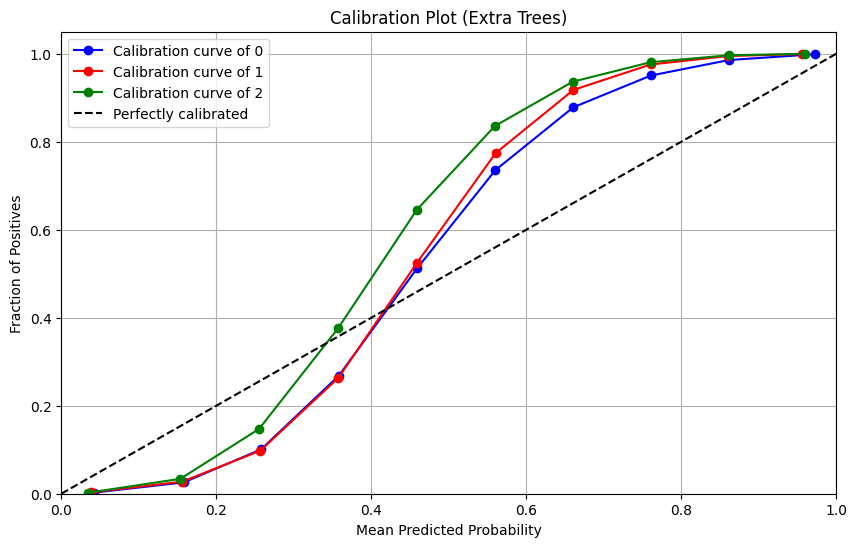


=== Calibration Scores ===
0: 0.120
1: 0.135
2: 0.141

=== Calibration Analysis (CatBoost) ===


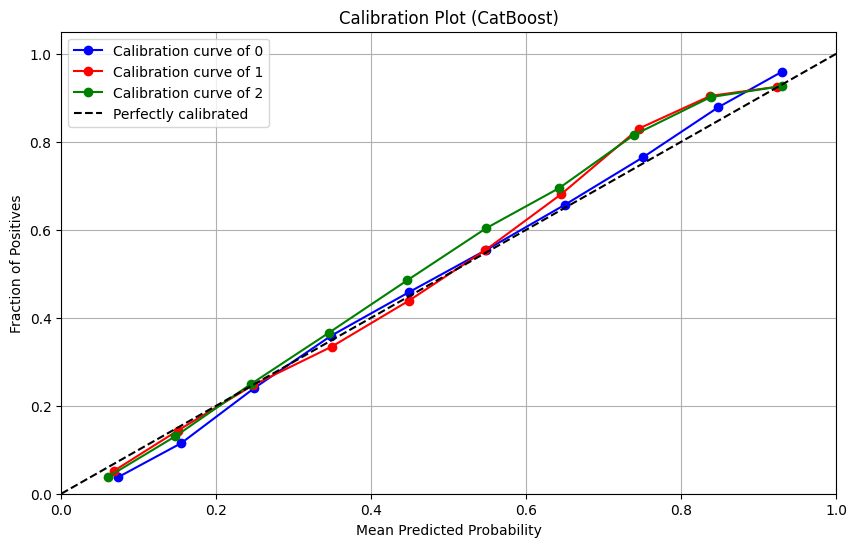


=== Calibration Scores ===
0: 0.019
1: 0.024
2: 0.035

=== Calibration Analysis (LightGBM) ===


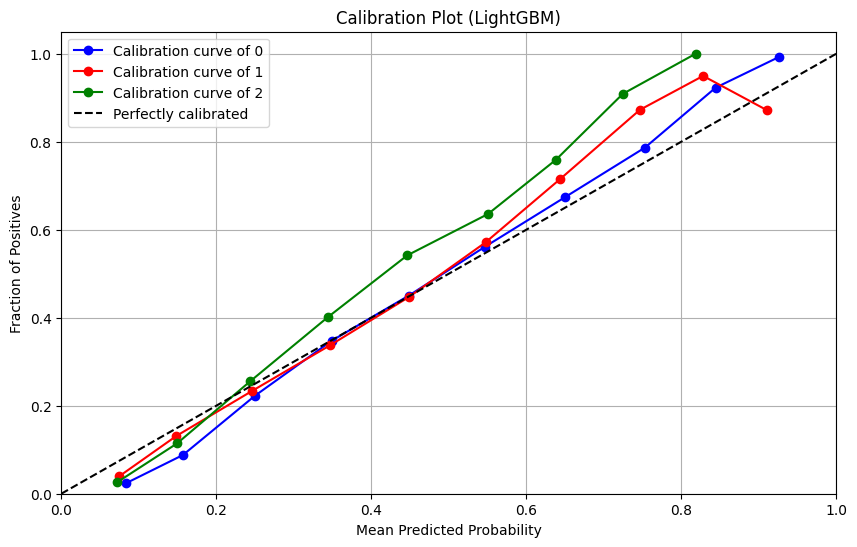


=== Calibration Scores ===
0: 0.038
1: 0.046
2: 0.091


In [ ]:
for name, model in models.items():
    print(f"\n=== Calibration Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 Calibration 정보 저장
    prob_true = dict()
    prob_pred = dict()
    calibration_scores = {}

    # 그래프 색상 설정
    colors = cycle(['blue', 'red', 'green'])

    # 캘리브레이션 곡선 계산
    plt.figure(figsize=(10, 6))
    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        prob_true[i], prob_pred[i] = calibration_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 변환
            y_pred_proba[:, i],
            n_bins=10
        )
        # 신뢰도 계산 (절대 오차의 평균)
        calibration_scores[class_name] = np.mean(np.abs(prob_true[i] - prob_pred[i]))

        # Calibration Curve 그리기
        plt.plot(
            prob_pred[i],
            prob_true[i],
            marker='o',
            color=color,
            label=f'Calibration curve of {class_name}'
        )

    # 완벽히 보정된 모델 기준선 추가
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Plot ({name})')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # Calibration Score 출력
    print("\n=== Calibration Scores ===")
    for class_name, score in calibration_scores.items():
        print(f"{class_name}: {score:.3f}")

In [ ]:
# for name, model in models.items():
#     print(f"\n=== Feature Importance Analysis ({name}) ===")

#     # Feature Importance 계산
#     if hasattr(model, "feature_importances_"):
#         importance = model.feature_importances_
#         feature_names = X.columns

#         importance_df = pd.DataFrame({
#             'Feature': feature_names,
#             'Importance': importance
#         }).sort_values(by='Importance', ascending=False)

#         # Feature Importance 시각화
#         plt.figure(figsize=(12, 10))
#         sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
#         plt.title(f'Feature Importance ({name})')
#         plt.xlabel('Importance')
#         plt.ylabel('Feature')
#         plt.grid(True)
#         plt.show()

#         # Feature Importance 상위 20개 출력
#         print(f"\n=== Feature Importance ({name}) ===")
#         print(importance_df.head(20))

#     else:
#         print(f"⚠ {name} 모델은 feature_importances_ 속성을 지원하지 않습니다.")

In [ ]:
# import os
# os.environ["XLA_USE_BF16"] = "1"


In [ ]:
# import shap
# import numpy as np

# # SHAP Explainer 생성
# explainer = shap.TreeExplainer(model)

# # 데이터 샘플링 (예: 10,000개씩 나눠서 처리)
# batch_size = 10000  # 원하는 크기로 조정 가능
# num_batches = int(np.ceil(len(X) / batch_size))

# shap_values_list = []

# for i in range(num_batches):
#     print(f"Processing batch {i+1}/{num_batches}...")
#     batch_data = X.iloc[i * batch_size : (i + 1) * batch_size]
#     shap_values_batch = explainer.shap_values(batch_data)
#     shap_values_list.append(shap_values_batch)

# # 모든 배치의 SHAP 값을 합치기
# shap_values = np.concatenate(shap_values_list, axis=1)

# # SHAP 시각화
# shap.summary_plot(shap_values, X)

